<a href="https://colab.research.google.com/github/djferranti/RegularizedStokesletsTutorial/blob/main/moments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Spherical Centroidal Voronoi Tesselation (SCVT)* \\
Algorithm for generating an approximately uniform distribution of points on a sphere.

In [1]:
import numpy as np
from scipy.spatial import SphericalVoronoi
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting
def spherical_triangle_area(a, b, c):
    """
    Compute the area of a spherical triangle on the unit sphere using L'Huilier's formula.
    """
    # Compute the side lengths (arc lengths) on the unit sphere
    a_len = np.arccos(np.clip(np.dot(b, c), -1.0, 1.0))
    b_len = np.arccos(np.clip(np.dot(c, a), -1.0, 1.0))
    c_len = np.arccos(np.clip(np.dot(a, b), -1.0, 1.0))

    s = 0.5 * (a_len + b_len + c_len)
    tan_e4 = np.tan(s / 2) * np.tan((s - a_len) / 2) * np.tan((s - b_len) / 2) * np.tan((s - c_len) / 2)
    excess = 4 * np.arctan(np.sqrt(np.abs(tan_e4)))

    return excess  # for unit sphere

def spherical_polygon_area(vertices):
    """
    Compute area of a spherical polygon by dividing into triangles.
    """
    if len(vertices) < 3:
        return 0.0

    area = 0.0
    ref = vertices[0]
    for i in range(1, len(vertices) - 1):
        a = ref
        b = vertices[i]
        c = vertices[i + 1]
        area += spherical_triangle_area(a, b, c)

    return area

def spherical_cvt_with_areas(n_points, n_iters=50, tol=1e-6, radius=1.0, center=np.array([0, 0, 0])):
    """
    Generate a spherical centroidal Voronoi tessellation and return generator points and their areas.

    Parameters
    ----------
    n_points : int
        Number of points on the sphere.
    n_iters : int
        Maximum number of Lloyd iterations.
    tol : float
        Convergence tolerance.
    radius : float
        Radius of the sphere.
    center : ndarray, shape (3,)
        Center of the sphere.

    Returns
    -------
    points : ndarray, shape (n_points, 3)
        Final CVT points on the sphere.
    areas : ndarray, shape (n_points,)
        Area of each Voronoi cell.
    """
    # Start with random points on the sphere
    points = np.random.randn(n_points, 3)
    points /= np.linalg.norm(points, axis=1)[:, np.newaxis]
    points = radius * points + center

    for i in range(n_iters):
        sv = SphericalVoronoi(points, radius=radius, center=center)
        sv.sort_vertices_of_regions()

        new_points = np.zeros_like(points)

        for j, region in enumerate(sv.regions):
            verts = sv.vertices[region]
            centroid = np.mean(verts, axis=0)
            centroid /= np.linalg.norm(centroid)  # Project back to sphere
            new_points[j] = centroid * radius + center

        delta = np.linalg.norm(new_points - points, axis=1).max()
        points = new_points

        if delta < tol:
            break

    areas = []
    for region in sv.regions:
        verts = sv.vertices[region]
        area = spherical_polygon_area(verts)
        areas.append(area)

    areas = np.array(areas)

    return points, areas

Generate a point cloud using the *spherical_cvt* function defined above and plot using matplotlib.

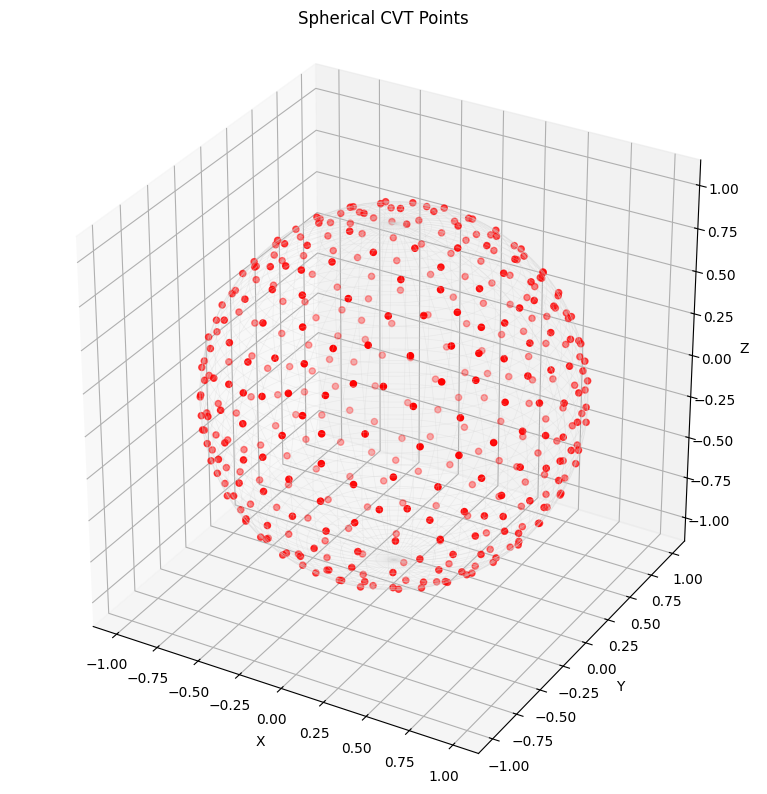

In [2]:
# Assume `points_sphere` is your Nx3 array from spherical_cvt_with_areas
# radius = a = 1
a = 1
n_points_sphere = 400
points_sphere, areas_points_sphere = spherical_cvt_with_areas(n_points=n_points_sphere, n_iters=20, radius = a)

# Create a 3D figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the unit sphere wireframe for context
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones_like(u), np.cos(v))
ax.plot_wireframe(x, y, z, color='lightgray', alpha=0.3, linewidth=0.5)

# Scatter plot of the CVT points
ax.scatter(points_sphere[:, 0], points_sphere[:, 1], points_sphere[:, 2], color='red', s=20)

# Axis properties
ax.set_box_aspect([1, 1, 1])
ax.set_title("Spherical CVT Points")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.tight_layout()
plt.show()

Evaluate velocity at several points on an annulus surrounding the sphere using

1.   The 7/2 blob
2.   The 9/2 blob (zero second moment)

The *hydrodynamic traction* (opposite the direction of sphere velocity) on the sphere is $$\mathbf{f} = -\frac{3 \mu}{2a} \mathbf{U}$$ where $\mathbf{U}$ is the uniform velocity of the translating sphere, $a$ is the sphere radius, and $\mu$ is the dynamic viscosity.

In [3]:
import numpy as np

def H1_72(r_reg, reg):
    h1 = 1 / (8 * np.pi) * (1 / r_reg + (reg ** 2) / (r_reg ** 3))
    return np.tile(h1[:, np.newaxis], (1, 3))

def H2_72(r_reg, reg):
    h2 = 1 / (8 * np.pi * r_reg ** 3)
    return np.tile(h2[:, np.newaxis], (1, 3))

def H1_92(r_reg, reg):
    h1 = 3 * reg**4 / (16 * np.pi * r_reg**5) + reg**2 / (16 * np.pi * r_reg**3) + 1 / (8 * np.pi * r_reg)
    return np.tile(h1[:, np.newaxis], (1, 3))

def H2_92(r_reg, reg):
    h2 = 1 / (8 * np.pi * r_reg**3) + 3 * reg**2 / (16 * np.pi * r_reg**5)
    return np.tile(h2[:, np.newaxis], (1, 3))

def reg_stokeslet_72(X_eval, X_force, F, reg):
    M = X_eval.shape[0]
    N = X_force.shape[0]

    U = np.zeros((M, 3))

    for j in range(N):
        rvec = X_eval - X_force[j]          # (M, 3)
        r2 = np.sum(rvec**2, axis=1)        # (M,)
        r_reg = np.sqrt(r2 + reg**2)        # (M,) Regularized distance

        h1 = H1_72(r_reg, reg)              # (M, 3)
        h2 = H2_72(r_reg, reg)              # (M, 3)

        Fj = F[j]                           # (3,)
        fdotr = np.sum(rvec * Fj, axis=1)[:, None]  # (M, 1)

        U += h1 * Fj + h2 * fdotr * rvec

    return U

def reg_stokeslet_92(X_eval, X_force, F, reg):
    M = X_eval.shape[0]
    N = X_force.shape[0]

    U = np.zeros((M, 3))

    for j in range(N):
        rvec = X_eval - X_force[j]          # (M, 3)
        r2 = np.sum(rvec**2, axis=1)        # (M,)
        r_reg = np.sqrt(r2 + reg**2)        # (M,) Regularized distance

        h1 = H1_92(r_reg, reg)              # (M, 3)
        h2 = H2_92(r_reg, reg)              # (M, 3)

        Fj = F[j]                           # (3,)
        fdotr = np.sum(rvec * Fj, axis=1)[:, None]  # (M, 1)

        U += h1 * Fj + h2 * fdotr * rvec

    return U


In [5]:
#get points in annulus from inner radius R0 to outer raidus R1

#inner and outer radii (R0, R1)
R0 = 1
R1 = 2

#use polar coordinates
n_points_r = 30
n_points_theta = 30
radii = np.linspace(a, R1, n_points_r)
thetas = np.linspace(0, 2*np.pi, n_points_theta, endpoint = False)

#output as a grid in X,Y,Z using outer product
X = np.outer(radii, np.cos(thetas))
Y = np.outer(radii, np.sin(thetas))
Z = np.zeros_like(X)

#get points in disc of radius R1
points_annulus = np.vstack([X.flatten(), Y.flatten(), Z.flatten()]).T
r_annulus = np.sqrt(np.sum(points_annulus * points_annulus, 1) )

#get points in annulus for R0 < radius < R1
# points_annulus_near = points_disc[r < 1.1 * R0, :]
# points_annulus_far  = points_disc[r > 1.5 * R0, :]
# r_annulus_near = r[r < 1.1 * R0]
# r_annulus_far =  r[r > 1.5 * R0]

In [6]:
#viscosity
mu = 1
#components of sphere's translational velocity
u_x = 1
u_y = 0
u_z = 0

#sphere's translational velocity
U_sphere = np.tile([u_x,u_y,u_z], (n_points_sphere, 1))
#force density
F = 3 * mu / (2 * a) * U_sphere * areas_points_sphere[:, np.newaxis]

#exact velocity field
u_x_annulus = 3 * a * u_x / 4 * (1 / r_annulus**3 - a ** 2 / r_annulus**5) * points_annulus[:, 0] ** 2 + a * u_x / (4 * r_annulus) * (3 + a**2 / r_annulus**2)
u_y_annulus = 3 * a * u_x / 4 * (1 / r_annulus**3 - a**2 / r_annulus**5) * points_annulus[:,0] * points_annulus[:,1]
u_z_annulus = 3 * a * u_x / 4 * (1 / r_annulus**3 - a**2 / r_annulus**5) * points_annulus[:,0] * points_annulus[:,2]

U_analytical = np.vstack([u_x_annulus, u_y_annulus, u_z_annulus]).T
U_analytical_norm = np.sqrt(np.sum(U_analytical * U_analytical, axis=1))

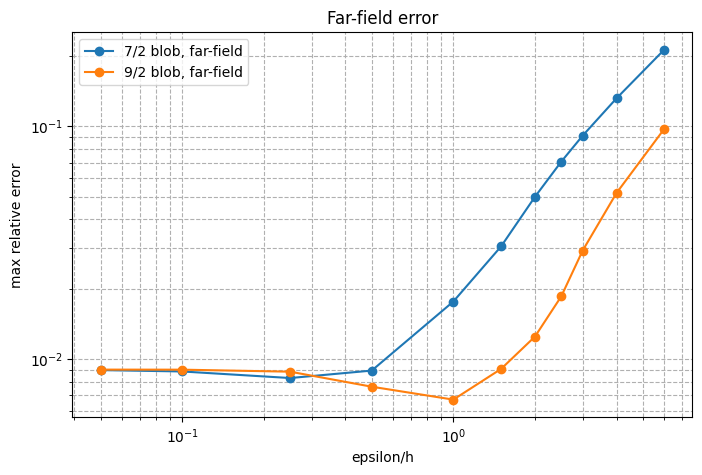

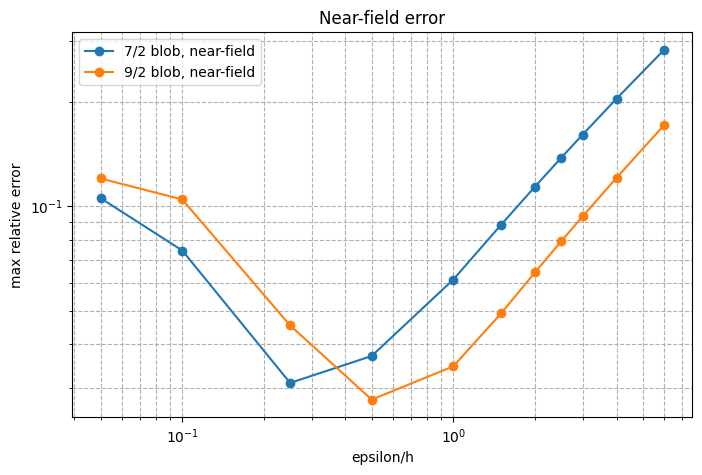

In [16]:
#average spatial discretization length
avg_h = np.sqrt(np.mean(areas_points_sphere))

#regularizations to try
regularizations = avg_h * np.array([6, 4, 3, 5/2, 2, 3/2, 1, 0.5, 0.25, 0.1, 0.05])
max_far_rel_errors_72 = np.zeros_like(regularizations)
max_near_rel_errors_72 = np.zeros_like(regularizations)
max_far_rel_errors_92 = np.zeros_like(regularizations)
max_near_rel_errors_92 = np.zeros_like(regularizations)

for i in range(len(regularizations)):
  reg = regularizations[i]

  #velocity evaluation for 7/2 blob
  U_72 = reg_stokeslet_72(points_annulus, points_sphere, F, reg)
  U_92 = reg_stokeslet_92(points_annulus, points_sphere, F, reg)

  #evaluate errors
  error_72 = (U_72 - U_analytical)
  error_92 = (U_92 - U_analytical)

  #evaluate relative errors for near-field and far-field
  rel_error_72 = np.sqrt(np.sum(error_72 * error_72, axis = 1)) / U_analytical_norm
  near_field_rel_error_72 = rel_error_72[r_annulus < 1.1 * R0]
  far_field_rel_error_72 = rel_error_72[r_annulus > 1.1 * R0]

  rel_error_92 = np.sqrt(np.sum(error_92 * error_92, axis = 1)) / U_analytical_norm
  near_field_rel_error_92 = rel_error_92[r_annulus < 1.1 * R0]
  far_field_rel_error_92 = rel_error_92[r_annulus > 1.1 * R0]

  #get max relative errors for near and far field
  max_near_rel_errors_72[i] = np.max(near_field_rel_error_72)
  max_far_rel_errors_72[i] = np.max(far_field_rel_error_72)

  max_near_rel_errors_92[i] = np.max(near_field_rel_error_92)
  max_far_rel_errors_92[i] = np.max(far_field_rel_error_92)

plt.figure(figsize=(8, 5))
plt.loglog(regularizations / avg_h, max_far_rel_errors_72, 'o-', label='7/2 blob, far-field')
plt.loglog(regularizations / avg_h, max_far_rel_errors_92, 'o-', label='9/2 blob, far-field')

plt.xlabel('epsilon/h')
plt.ylabel('max relative error')
plt.title('Far-field error')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.loglog(regularizations / avg_h, max_near_rel_errors_72, 'o-', label='7/2 blob, near-field')
plt.loglog(regularizations / avg_h, max_near_rel_errors_92, 'o-', label='9/2 blob, near-field')

plt.xlabel('epsilon/h')
plt.ylabel('max relative error')
plt.title('Near-field error')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()